<a href="https://colab.research.google.com/github/Chetan2003/FPGAHackathon/blob/main/rttDrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
STEP 1: Loading data
  Loaded drone data/rtt_log_run1.csv: 2990 rows
  Loaded drone data/rtt_log_run2.csv: 2990 rows
  Loaded drone data/rtt_log_run3.csv: 2990 rows
  Loaded drone data/rtt_log_run4.csv: 2990 rows
  Loaded drone data/rtt_log_run5.csv: 2990 rows
  Loaded drone data/rtt_log_run6.csv: 2990 rows
  Loaded drone data/rtt_log_run7.csv: 2990 rows
  Loaded drone data/rtt_log_run8.csv: 2990 rows
Total rows: 23920

STEP 2: Engineering features
Feature stats:
           rtt_ms   delta_rtt  rolling_std    rssi_dbm  rssi_rolling_std  \
count  23920.0000  23920.0000   23920.0000  23920.0000        23920.0000   
mean       1.8677     -0.0018       1.5131    -65.4520            0.0175   
std        2.8615      3.5902       2.0379      2.9426            0.0088   
min        0.1993    -86.9707       0.0000    -70.2562            0.0000   
25%        0.2049     -0.6786       0.0029    -67.9187            0.0099   
50%        0.7147     -0.0023       1.1203    -65.8490   

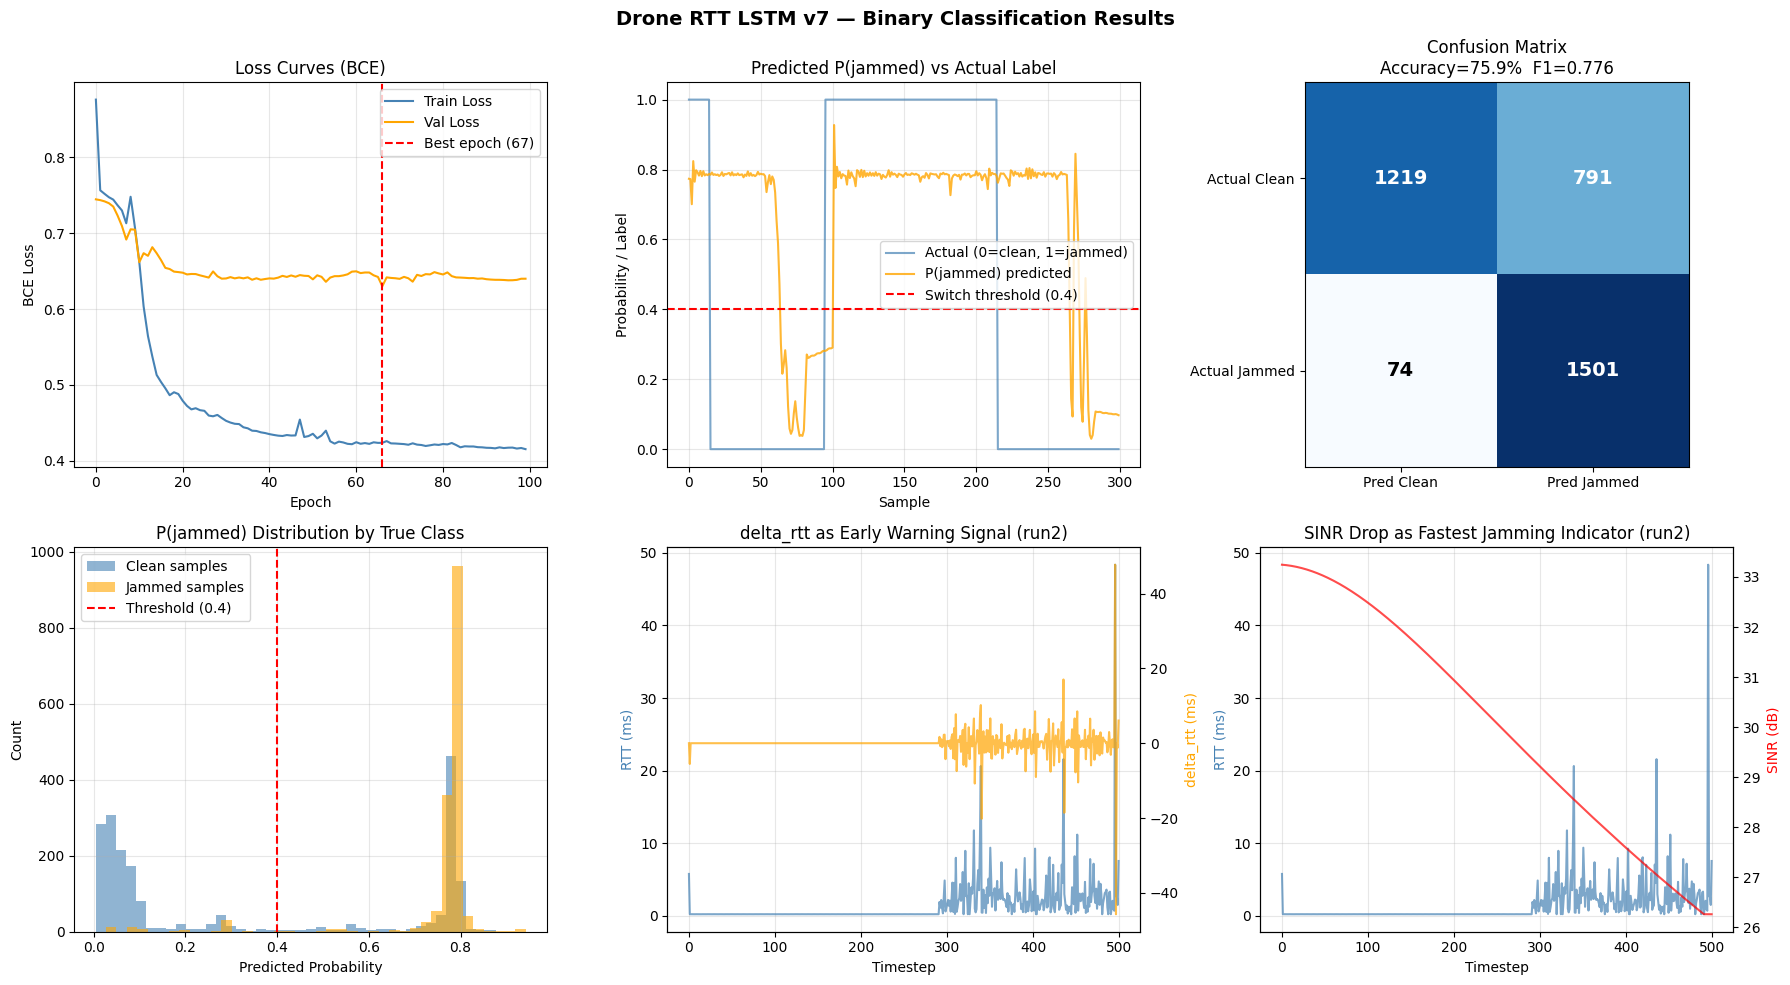

In [4]:
# =============================================================
# Drone RTT Prediction — PyTorch LSTM Training Script v5
# =============================================================
# Strategy: v2 stability + engineered features only
#   - No oversampling (broke temporal order in v3)
#   - No WeightedRandomSampler (broke training in v4)
#   - Engineered features: delta_rtt, rolling_std, delta_rssi
#   - BCEWithLogitsLoss with pos_weight for class imbalance handling
#   - Dropout 0.2 from v2
#
# This is the cleanest version — stable training with richer
# input features to help the LSTM detect jamming onset earlier.
#
# Usage:
#   pip install torch pandas scikit-learn matplotlib numpy
#   python lstm_train.py
# =============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ─────────────────────────────────────────────
# CONFIG
# ─────────────────────────────────────────────
CSV_FILES = [
    "drone data/rtt_log_run1.csv",
    "drone data/rtt_log_run2.csv",
    "drone data/rtt_log_run3.csv",
    "drone data/rtt_log_run4.csv",
    "drone data/rtt_log_run5.csv",
    "drone data/rtt_log_run6.csv",
    "drone data/rtt_log_run7.csv",  # moderate power (45dBm)
    "drone data/rtt_log_run8.csv",  # severe power (75dBm)
]

FEATURES = [
    "rtt_ms",           # core signal
    "delta_rtt",        # step-to-step RTT change — early warning
    "rolling_std",      # 5-step RTT std dev — jamming onset
    "rssi_dbm",         # signal strength
    "rssi_rolling_std", # RSSI stability — separates jamming from distance
    "sinr_db",          # signal-to-noise ratio — fastest jamming indicator
]

PREDICT_HORIZON = 5     # predict 500ms ahead
WINDOW_SIZE     = 20    # 2 seconds of history
HIDDEN_SIZE_1   = 32
HIDDEN_SIZE_2   = 16
EPOCHS          = 100
BATCH_SIZE      = 64
LEARNING_RATE   = 0.001
TRAIN_RATIO     = 0.70
VAL_RATIO       = 0.15

# Binary classification threshold
# if predicted P(jammed) > DECISION_THRESHOLD → trigger channel switch
DECISION_THRESHOLD = 0.40  # set between clean peak (~0.08) and jammed peak (~0.65)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# =============================================================
# STEP 1 — Load CSVs
# =============================================================
def load_data(csv_files):
    frames = []
    for f in csv_files:
        if not os.path.exists(f):
            print(f"  WARNING: {f} not found, skipping.")
            continue
        df = pd.read_csv(f)
        df["run"] = f
        frames.append(df)
        print(f"  Loaded {f}: {len(df)} rows")
    combined = pd.concat(frames, ignore_index=True)
    print(f"Total rows: {len(combined)}")
    return combined

print("=" * 55)
print("STEP 1: Loading data")
print("=" * 55)
df = load_data(CSV_FILES)


# =============================================================
# STEP 2 — Feature Engineering (per-run, no cross-run leakage)
# =============================================================
print("\n" + "=" * 55)
print("STEP 2: Engineering features")
print("=" * 55)

def engineer_features(df):
    df = df.copy()
    df["delta_rtt"]        = 0.0
    df["rolling_std"]      = 0.0
    df["rssi_rolling_std"] = 0.0
    # sinr_db comes directly from CSV — no engineering needed

    for run_name, group in df.groupby("run"):
        idx = group.index

        # delta_rtt: RTT change per step — fires at jamming onset
        df.loc[idx, "delta_rtt"] = group["rtt_ms"].diff().fillna(0.0).values

        # rolling_std: 5-step RTT std deviation — measures RTT instability
        df.loc[idx, "rolling_std"] = (
            group["rtt_ms"].rolling(5, min_periods=1).std().fillna(0.0).values
        )

        # rssi_rolling_std: 5-step RSSI std deviation
        # Jammer causes rapid RSSI fluctuation even when average RSSI
        # doesn't drop much — separates jamming from distance degradation
        df.loc[idx, "rssi_rolling_std"] = (
            group["rssi_dbm"].rolling(5, min_periods=1).std().fillna(0.0).values
        )

    return df

df = engineer_features(df)
print("Feature stats:")
print(df[FEATURES].describe().round(4))


# =============================================================
# STEP 3 — Normalize (fit on train only)
# =============================================================
print("\n" + "=" * 55)
print("STEP 3: Normalizing features + building binary labels")
print("=" * 55)

feature_data = df[FEATURES].values.astype(np.float32)

# Binary target: jammer_active column (already includes grace period fix from NS3)
# Shifted by PREDICT_HORIZON so model predicts jamming 500ms AHEAD
target_data  = df["jammer_active"].values.astype(np.float32)

n         = len(feature_data)
train_end = int(n * TRAIN_RATIO)
val_end   = int(n * (TRAIN_RATIO + VAL_RATIO))

# Normalize features only — target is already 0/1 binary
feature_scaler = MinMaxScaler()
feature_scaler.fit(feature_data[:train_end])
feature_scaled = feature_scaler.transform(feature_data)

# No target scaler needed for classification
print("Feature ranges (from training data):")
for i, fname in enumerate(FEATURES):
    print(f"  {fname:<20}: [{feature_scaler.data_min_[i]:.4f}, {feature_scaler.data_max_[i]:.4f}]")

# Class balance
jammed_count = int(target_data.sum())
clean_count  = len(target_data) - jammed_count
print(f"\nClass balance:")
print(f"  Jammed (1): {jammed_count} ({100*jammed_count/len(target_data):.1f}%)")
print(f"  Clean  (0): {clean_count}  ({100*clean_count/len(target_data):.1f}%)")

# pos_weight for BCE loss — penalizes missing jammed periods more
# = (clean count / jammed count) weighted toward catching jamming
pos_weight = clean_count / jammed_count
print(f"  BCE pos_weight: {pos_weight:.2f}  (jammed misses cost {pos_weight:.1f}x more)")

np.save("scaler_params.npy", {
    "feature_min":  feature_scaler.data_min_,
    "feature_max":  feature_scaler.data_max_,
    "features":     FEATURES,
    "window_size":  WINDOW_SIZE,
    "horizon":      PREDICT_HORIZON,
    "mode":         "classification",
    "threshold":    DECISION_THRESHOLD,
})
print("Saved → scaler_params.npy")


# =============================================================
# STEP 4 — Sliding window (chronological order preserved)
# =============================================================
print("\n" + "=" * 55)
print("STEP 4: Building sequences")
print("=" * 55)

def make_sequences(features, targets, window, horizon):
    X, y = [], []
    for i in range(window, len(features) - horizon):
        X.append(features[i - window : i])   # past window of features
        y.append(targets[i + horizon])        # jammer state 500ms ahead
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = make_sequences(feature_scaled, target_data, WINDOW_SIZE, PREDICT_HORIZON)
print(f"X shape: {X.shape}  →  (samples, window={WINDOW_SIZE}, features={len(FEATURES)})")
print(f"y shape: {y.shape}  →  binary labels (0=clean, 1=jammed)")

n_seq         = len(X)
train_end_seq = int(n_seq * TRAIN_RATIO)
val_end_seq   = int(n_seq * (TRAIN_RATIO + VAL_RATIO))

X_train, y_train = X[:train_end_seq],            y[:train_end_seq]
X_val,   y_val   = X[train_end_seq:val_end_seq], y[train_end_seq:val_end_seq]
X_test,  y_test  = X[val_end_seq:],              y[val_end_seq:]

print(f"Train: {len(X_train)}  Val: {len(X_val)}  Test: {len(X_test)}")


# =============================================================
# STEP 5 — Dataset and DataLoader (no shuffling — time series)
# =============================================================
class RTTDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    def __len__(self):   return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

train_loader = DataLoader(RTTDataset(X_train, y_train),
                          batch_size=BATCH_SIZE, shuffle=False)
val_loader   = DataLoader(RTTDataset(X_val,   y_val),
                          batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(RTTDataset(X_test,  y_test),
                          batch_size=BATCH_SIZE, shuffle=False)


# =============================================================
# STEP 6 — LSTM Model (same as v2, input_size now 6)
# =============================================================
class DroneRTTLSTM(nn.Module):
    def __init__(self, input_size, hidden1, hidden2):
        super().__init__()
        self.lstm1    = nn.LSTM(input_size, hidden1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2    = nn.LSTM(hidden1, hidden2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc       = nn.Linear(hidden2, 1)
        # No sigmoid here — BCEWithLogitsLoss applies it internally
        # (numerically more stable than manual sigmoid + BCELoss)

    def forward(self, x):
        out, _      = self.lstm1(x)
        out         = self.dropout1(out)
        out, _      = self.lstm2(out)
        last        = out[:, -1, :]
        last        = self.dropout2(last)
        return self.fc(last)   # raw logit — not probability yet

model = DroneRTTLSTM(len(FEATURES), HIDDEN_SIZE_1, HIDDEN_SIZE_2).to(DEVICE)
print("\n" + "=" * 55)
print("STEP 5: Model")
print("=" * 55)
print(model)
total = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTrainable parameters: {total}")

# BCEWithLogitsLoss — binary cross entropy with pos_weight
# pos_weight = clean/jammed ratio — makes missing a jammed period
# cost pos_weight times more than a false alarm
# This directly optimizes detection rate without any oversampling
pw = torch.tensor([pos_weight]).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=15)  # patience 10→15


# =============================================================
# STEP 8 — Training loop
# =============================================================
train_losses, val_losses = [], []
best_val_loss, best_epoch = float('inf'), 0

print("\n" + "=" * 55)
print("STEP 6: Training")
print("=" * 55)

for epoch in range(1, EPOCHS + 1):
    # Train
    model.train()
    train_loss = 0.0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item() * len(Xb)
    train_loss /= len(train_loader.dataset)

    # Validate
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            val_loss += criterion(model(Xb), yb).item() * len(Xb)
    val_loss /= len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch    = epoch
        torch.save(model.state_dict(), "rtt_lstm.pt")

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch [{epoch:3d}/{EPOCHS}]  "
              f"Train: {train_loss:.6f}  Val: {val_loss:.6f}"
              + (" ← best" if epoch == best_epoch else ""))

print(f"\nBest epoch {best_epoch} (val={best_val_loss:.6f}) → rtt_lstm.pt")


# =============================================================
# STEP 9 — Evaluation
# =============================================================
print("\n" + "=" * 55)
print("STEP 7: Evaluation")
print("=" * 55)

model.load_state_dict(torch.load("rtt_lstm.pt", map_location=DEVICE))
model.eval()

all_logits, all_true = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        logits = model(Xb.to(DEVICE)).cpu().numpy().flatten()
        all_logits.extend(logits)
        all_true.extend(yb.cpu().numpy().flatten())

all_logits = np.array(all_logits)
all_true   = np.array(all_true).astype(int)

# Convert logits → probabilities → binary predictions
probs      = 1 / (1 + np.exp(-all_logits))   # sigmoid
pred_class = (probs > DECISION_THRESHOLD).astype(int)

tp = np.sum((pred_class==1) & (all_true==1))
tn = np.sum((pred_class==0) & (all_true==0))
fp = np.sum((pred_class==1) & (all_true==0))
fn = np.sum((pred_class==0) & (all_true==1))

precision = tp / (tp + fp + 1e-8)
recall    = tp / (tp + fn + 1e-8)
f1        = 2 * precision * recall / (precision + recall + 1e-8)
accuracy  = (tp + tn) / (tp + tn + fp + fn)
fpr       = fp / (fp + tn + 1e-8)

print(f"Accuracy  : {accuracy:.3f}  ({100*accuracy:.1f}%)")
print(f"Precision : {precision:.3f}")
print(f"Recall    : {recall:.3f}   (detection rate — higher = fewer missed jams)")
print(f"F1 Score  : {f1:.3f}")
print(f"False alarm rate : {fpr:.3f}  ({100*fpr:.1f}% of clean periods trigger switch)")
print(f"\nConfusion matrix:")
print(f"  TP={tp}  FP={fp}")
print(f"  FN={fn}  TN={tn}")


# =============================================================
# STEP 10 — Plots
# =============================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Drone RTT LSTM v7 — Binary Classification Results", fontsize=14, fontweight='bold')

# Loss curves
axes[0,0].plot(train_losses, label="Train Loss", color="steelblue")
axes[0,0].plot(val_losses,   label="Val Loss",   color="orange")
axes[0,0].axvline(best_epoch-1, color='red', linestyle='--',
                   label=f"Best epoch ({best_epoch})")
axes[0,0].set_title("Loss Curves (BCE)")
axes[0,0].set_xlabel("Epoch"); axes[0,0].set_ylabel("BCE Loss")
axes[0,0].legend(); axes[0,0].grid(True, alpha=0.3)

# Predicted probability vs true label
n_show = min(300, len(all_true))
axes[0,1].plot(all_true[:n_show],  label="Actual (0=clean, 1=jammed)",
               color="steelblue", alpha=0.7)
axes[0,1].plot(probs[:n_show],     label="P(jammed) predicted",
               color="orange",    alpha=0.8)
axes[0,1].axhline(DECISION_THRESHOLD, color='red', linestyle='--',
                   label=f"Switch threshold ({DECISION_THRESHOLD})")
axes[0,1].set_title(f"Predicted P(jammed) vs Actual Label")
axes[0,1].set_xlabel("Sample"); axes[0,1].set_ylabel("Probability / Label")
axes[0,1].legend(); axes[0,1].grid(True, alpha=0.3)

# Confusion matrix heatmap
cm = np.array([[tn, fp], [fn, tp]])
im = axes[0,2].imshow(cm, cmap='Blues')
axes[0,2].set_xticks([0,1]); axes[0,2].set_yticks([0,1])
axes[0,2].set_xticklabels(["Pred Clean","Pred Jammed"])
axes[0,2].set_yticklabels(["Actual Clean","Actual Jammed"])
axes[0,2].set_title(f"Confusion Matrix\nAccuracy={accuracy:.1%}  F1={f1:.3f}")
for i in range(2):
    for j in range(2):
        axes[0,2].text(j, i, str(cm[i,j]), ha='center', va='center',
                       fontsize=14, fontweight='bold',
                       color='white' if cm[i,j] > cm.max()/2 else 'black')

# Probability distribution — clean vs jammed
clean_probs  = probs[all_true == 0]
jammed_probs = probs[all_true == 1]
axes[1,0].hist(clean_probs,  bins=40, alpha=0.6, color="steelblue", label="Clean samples")
axes[1,0].hist(jammed_probs, bins=40, alpha=0.6, color="orange",    label="Jammed samples")
axes[1,0].axvline(DECISION_THRESHOLD, color='red', linestyle='--',
                   label=f"Threshold ({DECISION_THRESHOLD})")
axes[1,0].set_title("P(jammed) Distribution by True Class")
axes[1,0].set_xlabel("Predicted Probability"); axes[1,0].set_ylabel("Count")
axes[1,0].legend(); axes[1,0].grid(True, alpha=0.3)

# delta_rtt early warning on run2
run2_mask  = df["run"].str.contains("run2")
run2_rtt   = df.loc[run2_mask, "rtt_ms"].values[:500]
run2_delt  = df.loc[run2_mask, "delta_rtt"].values[:500]
run2_sinr  = df.loc[run2_mask, "sinr_db"].values[:500]

ax5t = axes[1,1].twinx()
axes[1,1].plot(run2_rtt,  color="steelblue", alpha=0.7, label="RTT (run2)")
ax5t.plot(run2_delt,      color="orange",    alpha=0.7, label="delta_rtt")
axes[1,1].set_title("delta_rtt as Early Warning Signal (run2)")
axes[1,1].set_xlabel("Timestep")
axes[1,1].set_ylabel("RTT (ms)",   color="steelblue")
ax5t.set_ylabel("delta_rtt (ms)",  color="orange")
axes[1,1].grid(True, alpha=0.3)

# SINR — fastest jamming indicator
ax6t = axes[1,2].twinx()
axes[1,2].plot(run2_rtt,  color="steelblue", alpha=0.7, label="RTT (run2)")
ax6t.plot(run2_sinr,      color="red",       alpha=0.7, label="SINR (dB)")
axes[1,2].set_title("SINR Drop as Fastest Jamming Indicator (run2)")
axes[1,2].set_xlabel("Timestep")
axes[1,2].set_ylabel("RTT (ms)",  color="steelblue")
ax6t.set_ylabel("SINR (dB)",      color="red")
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_plot.png", dpi=150, bbox_inches='tight')
print("\nPlots saved → training_plot.png")


# =============================================================
# STEP 11 — Extract weights for Verilog
# =============================================================
print("\n" + "=" * 55)
print("STEP 8: Weights for Verilog")
print("=" * 55)

state = model.state_dict()
lines = ["="*60, "LSTM WEIGHT SUMMARY FOR VERILOG RTL", "="*60,
         f"Input features : {FEATURES}",
         f"Input size     : {len(FEATURES)}",
         f"Hidden1        : {HIDDEN_SIZE_1}",
         f"Hidden2        : {HIDDEN_SIZE_2}",
         f"Window size    : {WINDOW_SIZE}",
         f"Horizon        : {PREDICT_HORIZON} steps ({PREDICT_HORIZON*100}ms)", ""]

for name, param in state.items():
    arr = param.cpu().numpy()
    lines += [f"Layer : {name}",
              f"  Shape : {arr.shape}",
              f"  Min   : {arr.min():.6f}",
              f"  Max   : {arr.max():.6f}", ""]

H1    = HIDDEN_SIZE_1
w_ih1 = state['lstm1.weight_ih_l0'].cpu().numpy()
w_hh1 = state['lstm1.weight_hh_l0'].cpu().numpy()
lines += ["-"*60,
          "LSTM1 Gate Breakdown (for Verilog — 4 gates):",
          f"  W_ii input  gate input  weights : {w_ih1[:H1].shape}",
          f"  W_if forget gate input  weights : {w_ih1[H1:2*H1].shape}",
          f"  W_ig cell   gate input  weights : {w_ih1[2*H1:3*H1].shape}",
          f"  W_io output gate input  weights : {w_ih1[3*H1:].shape}",
          f"  W_hi input  gate hidden weights : {w_hh1[:H1].shape}",
          f"  W_hf forget gate hidden weights : {w_hh1[H1:2*H1].shape}",
          f"  W_hg cell   gate hidden weights : {w_hh1[2*H1:3*H1].shape}",
          f"  W_ho output gate hidden weights : {w_hh1[3*H1:].shape}", "",
          "Quantization (Q8.8): int16 = round(float * 256)",
          "sigmoid/tanh: implement as 256-entry LUT"]

summary = "\n".join(lines)
print(summary)
with open("weights_summary.txt","w") as f: f.write(summary)
np.save("lstm_weights.npy", {k: v.cpu().numpy() for k,v in state.items()})

print("\n" + "=" * 55)
print("DONE:")
print("  rtt_lstm.pt       — model weights")
print("  scaler_params.npy — normalization")
print("  lstm_weights.npy  — raw weights for Verilog")
print("  weights_summary.txt")
print("  training_plot.png")
print("=" * 55)